In [60]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [61]:
def branin(X, Y):
    a = 1.0
    b = 5.1 / (4.0 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8.0 * np.pi)
    
    return a * (Y - b * X**2 + c * X - r)**2 + s * (1 - t) * np.cos(X) + s


In [62]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [63]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, a, b: 0.1*(a - 4) * x + 0.05*(b + 3) * x**2 + r.normal(0, sim_stdev)

In [64]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 10, 10)
Y = np.random.uniform(0, 15, 10)

# Calculate the outputs using Branin and Currin functions
output1 = branin(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [65]:
sim_eval = lambda x, y, a, b: branin(x, y) + sim_err(x, a, b)

In [66]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (2,5)},
          {'name': 'b', 'type': 'continuous', 'domain': (-4,-1)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 3.95963037 -3.00534208]


In [67]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574


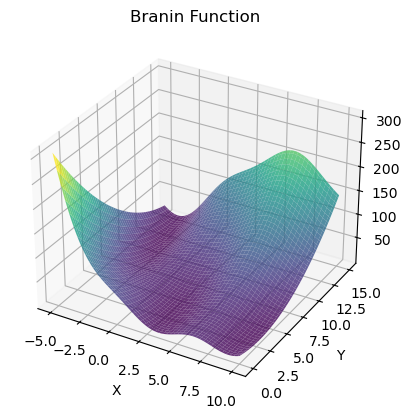

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 10, 100)
y_range = np.linspace(0, 15, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = branin(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Branin Function')

# Show the plot
plt.show()

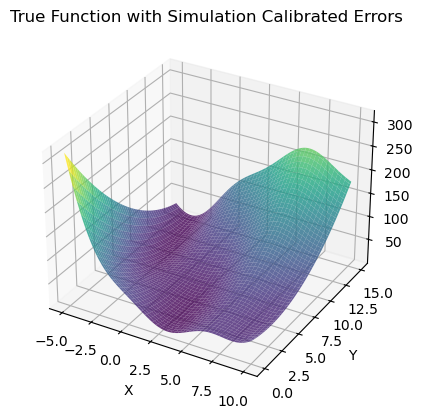

In [69]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[0])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [70]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [71]:
def perform_iteration(df):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-5, 10, 100)
    x2_range  = np.linspace(0, 15, 100)

    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # Perform MC Dropout predictions for entire meshgrid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

    # Define range for inputs
    bounds = np.array([[-5, 10], [0, 15]])

    # Identify top 10 points with highest uncertainty
    num_new_points = 10

    sampler = qmc.LatinHypercube(d=2)  # LHS in a 2D space
    lhs_sample = sampler.random(n=1000)
    lhs_points = qmc.scale(lhs_sample, bounds[:, 0], bounds[:, 1])

    lhs_mean, lhs_std = mc_dropout_predictions(best_model, lhs_points)
    percentile_threshold = 90 
    threshold_value = np.percentile(lhs_mean, percentile_threshold)

    # Filter points above the threshold
    points_above_threshold = lhs_points[lhs_mean >= threshold_value]

    num_new_points = 10
    if len(points_above_threshold) > num_new_points:
        selected_indices = np.random.choice(len(points_above_threshold), num_new_points, replace=False)
        selected_points = points_above_threshold[selected_indices]
    else:
        selected_points = points_above_threshold

    new_points_df = pd.DataFrame(selected_points, columns=['x','y'])

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot the high uncertainty points
    ax.scatter(selected_points[:, 0], selected_points[:, 1], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    # Add validated data points to original data frame
    new_points_df["z"] = branin(new_points_df['x'], new_points_df['y']) + ran_err(num_new_points, 0.05)
    new_points_df["a"] = bo.x_opt[0]
    new_points_df["b"] = bo.x_opt[1]
    new_points_df["sim_z"] = sim_eval(new_points_df["x"], new_points_df["y"], new_points_df["a"], new_points_df["b"])
    new_points_df["diff"] = new_points_df["z"] - new_points_df["sim_z"]

    df = pd.concat([df, new_points_df], axis=0, ignore_index=True)
    return df


Best hyperparameters:
num_layers: 6
num_units: 200
learning_rate: 0.0005511101435616244
dropout_rate: 0.5
batch_size: 116
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 7631.2529
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7620.3657
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7624.7368
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7623.6006
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7623.4531
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7601.0171
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7608.9126
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7601.4912
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7594.7334
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7576.4229
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7558.3232
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7571.2451
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/ste

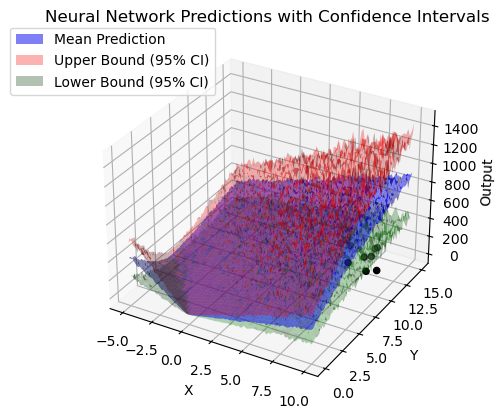

In [72]:
df = perform_iteration(df)

In [73]:
df = perform_iteration(df)

KeyboardInterrupt: 

In [ ]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574


Best hyperparameters:
num_layers: 3
num_units: 167
learning_rate: 0.006341747572503846
dropout_rate: 0.0
batch_size: 20
epochs: 153
Epoch 1/153
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5037.3643
Epoch 2/153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4276.0264 
Epoch 3/153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3870.8445 
Epoch 4/153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3131.7463 
Epoch 5/153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2227.9526 
Epoch 6/153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2068.6084 
Epoch 7/153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2318.3398 
Epoch 8/153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1454.4149 
Epoch 9/153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1391.0879 
Epoch 10/153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1219.4346 
Epoch 11/153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1217.8766 
Epoch 12/153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1193.4984 
Epoch 13/153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

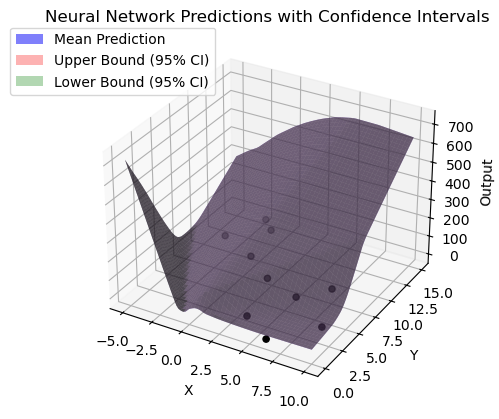

In [ ]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.018873731213846924
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step - loss: 3937.8250
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3739.2031
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3450.3875
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3017.8259
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2470.4451
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1917.4543
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1593.5233
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1691.4137
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1786.0531
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1596.4380
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1315.1582
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1122.0992
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

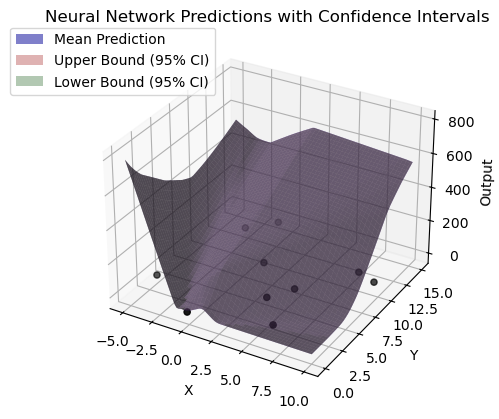

In [ ]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 5
num_units: 137
learning_rate: 0.0026291747211661426
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 4396.8120
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4376.2788
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4347.9814
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4303.0137
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4232.8413
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4125.4375
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3965.8201
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3737.6096
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3427.3093
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3035.2585
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2595.5408
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2224.5930
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/ste

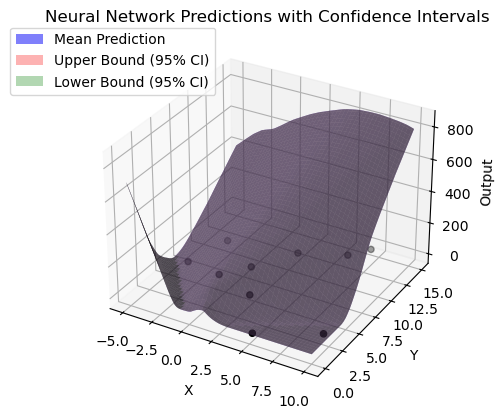

In [ ]:
df = perform_iteration(df)

In [ ]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574


In [ ]:
df = perform_iteration(df)

KeyboardInterrupt: 